# Using LittleVGG for Emotion Detection (9 Layers)

### Training Emotion Detector

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf #added by Elton


num_classes = 7
img_rows, img_cols = 48, 48
batch_size = 150
#batch_size = 16

train_data_dir = 'data/fer2013/train'
validation_data_dir = 'data/fer2013/validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Using TensorFlow backend.


Found 62348 images belonging to 7 classes.
Found 5743 images belonging to 7 classes.


In [2]:
#Added by KSL
#Save emotion list
import pandas as py
emotion_list = tuple(zip(train_generator.class_indices.values(), train_generator.class_indices.keys()))
print(emotion_list)

emotion_list = tuple(train_generator.class_indices.keys())
emotion_list = py.DataFrame(emotion_list)
emotion_list.to_csv("emotion-dict.csv", index=False, header=None)

((0, 'Angry'), (1, 'Disgusted'), (2, 'Fear'), (3, 'Happy'), (4, 'Neutral'), (5, 'Sad'), (6, 'Surprise'))


## Our Keras Imports

In [3]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense

## Keras LittleVGG Model

In [4]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #5: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
______________________________________

## Training our model

In [5]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("emotion.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
#ek modified the early stop
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

# we put our call backs into a callback list
#ek modified
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

nb_train_samples = 62348
nb_validation_samples = 5743
epochs = 100

history = model.fit_generator(
    train_generator, 
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)




Epoch 1/100
2003/2003 [==============================] - 241s 120ms/step - loss: 1.9626 - accuracy: 0.2074 - val_loss: 1.8438 - val_accuracy: 0.2739

Epoch 00001: val_loss improved from inf to 1.84381, saving model to emotion.h5
Epoch 2/100
2003/2003 [==============================] - 244s 122ms/step - loss: 1.6234 - accuracy: 0.3713 - val_loss: 1.5427 - val_accuracy: 0.4822

Epoch 00002: val_loss improved from 1.84381 to 1.54268, saving model to emotion.h5
Epoch 3/100
2003/2003 [==============================] - 249s 124ms/step - loss: 1.4454 - accuracy: 0.4559 - val_loss: 1.4965 - val_accuracy: 0.5174

Epoch 00003: val_loss improved from 1.54268 to 1.49647, saving model to emotion.h5
Epoch 4/100
2003/2003 [==============================] - 246s 123ms/step - loss: 1.3673 - accuracy: 0.4913 - val_loss: 1.2920 - val_accuracy: 0.5390

Epoch 00004: val_loss improved from 1.49647 to 1.29202, saving model to emotion.h5
Epoch 5/100
2003/2003 [==============================] - 243s 121ms/ste

In [6]:
#ek added
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [7]:
model.save("emotion.h5")
print("Saved emotion model to disk")

Saved emotion model to disk


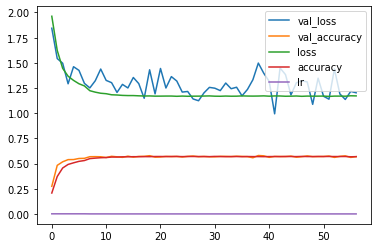

In [8]:
#added by KSL
# Evaluate training/validation performance
import pandas as pd

model_loss = pd.DataFrame(history.history)
model_loss.plot()

Found 5743 images belonging to 7 classes.
Confusion Matrix
[[618  38  47  15 115 142  25]
 [ 48 127   2   1   1  27   3]
 [ 90   6 144  18  80 138  58]
 [ 20   3   9 880  50  19  19]
 [183   5  45 155 226 304  82]
 [ 80  10  45  24 191 627  23]
 [ 46   5 119  58  68  52 652]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.57      0.62      0.59      1000
     Disgust       0.65      0.61      0.63       209
        Fear       0.35      0.27      0.30       534
       Happy       0.76      0.88      0.82      1000
     Neutral       0.31      0.23      0.26      1000
         Sad       0.48      0.63      0.54      1000
    Surprise       0.76      0.65      0.70      1000

    accuracy                           0.57      5743
   macro avg       0.55      0.55      0.55      5743
weighted avg       0.56      0.57      0.56      5743



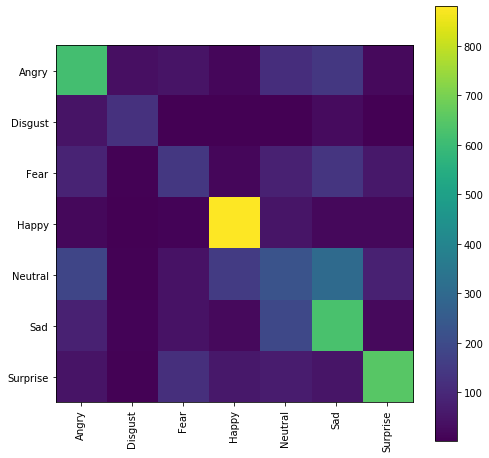

In [14]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_train_samples = 62348
nb_validation_samples = 5743

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

### Loading our saved model

In [1]:
from keras.models import load_model

classifier = load_model('emotion.h5')
model.load_weights('emotion.h5')

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




NameError: name 'model' is not defined